In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import graphviz 
import itertools

In [2]:
# function use to plot the confusion matrix
def plot_cm(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Preprocessing functions
Here are a couple of preprocessing function used to transform the data we load

In [3]:
def remove_slash_name(_df):
    df = _df.copy()
    df['Player'] = df['Player'].apply(lambda row: row.split('\\')[0])
    return df

def remove_rk(_df):
    df = _df.copy()
    return df.drop(['Rk'], axis=1)

def remove_team(_df):
    df = _df.copy()
    return df.drop(['Tm'], axis=1)

def remove_age(_df):
    df = _df.copy()
    return df.drop(['Age'], axis=1)

def remove_game(_df):
    df = _df.copy()
    return df.drop(['G'], axis=1)   

def remove_game_started(_df):
    df = _df.copy()
    return df.drop(['GS'], axis=1)   

def remove_min(_df):
    df = _df.copy()
    return df.drop(['MP'], axis=1)    

def extract_name_position(_df):
    df = _df.copy()
    return _df.drop(['Pos','Player'], axis=1), _df[['Player', 'Pos']]
    

def remove_nan(_df):
    df = _df.copy()
    return df.dropna(axis=1, how='all').fillna(0)

## Data extraction

In [4]:
# we use pandas to load data directly from csv
df = pd.read_csv('../data/adv_stats.csv')

# apply a couple of preprocessing function
df = remove_rk(remove_slash_name(df))
df = remove_age(remove_team(df))
df = remove_game(remove_min(df))

unique_pos = np.unique(df['Pos'])
for p in unique_pos:
    print("{} : {} entries".format(p,len(df.loc[df['Pos']==p].index)))

# We can see that only PG, SG, SF, PF and C are relevant as other listed position doesn't have enough entry
pos_used = ['PG','SG','SF','PF','C']
df = df.loc[df['Pos'].isin(pos_used)]

df, pos = extract_name_position(df)
df = remove_nan(df)

C : 120 entries
C-PF : 1 entries
PF : 147 entries
PF-C : 1 entries
PF-SF : 2 entries
PG : 139 entries
SF : 118 entries
SF-SG : 2 entries
SG : 176 entries
SG-PF : 1 entries
SG-SF : 1 entries


## Model creation

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [6]:
le = preprocessing.LabelEncoder()
y = pos['Pos'].values
le.fit(np.unique(y))
y = le.transform(y)

X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5, probability=True),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=8, n_estimators=150),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [8]:
# iterate over classifiers
scores = []
for name, clf in zip(names, classifiers):
    scores_ = []
    print('training model {}'.format(name))
    for _ in range(10):
        clf.fit(X_train, y_train)
        scores_.append(clf.score(X_test, y_test))
    scores.append(np.mean(scores_))

training model Nearest Neighbors
training model Linear SVM
training model RBF SVM
training model Decision Tree
training model Random Forest
training model Neural Net
training model AdaBoost
training model Naive Bayes
training model QDA


## All models performances

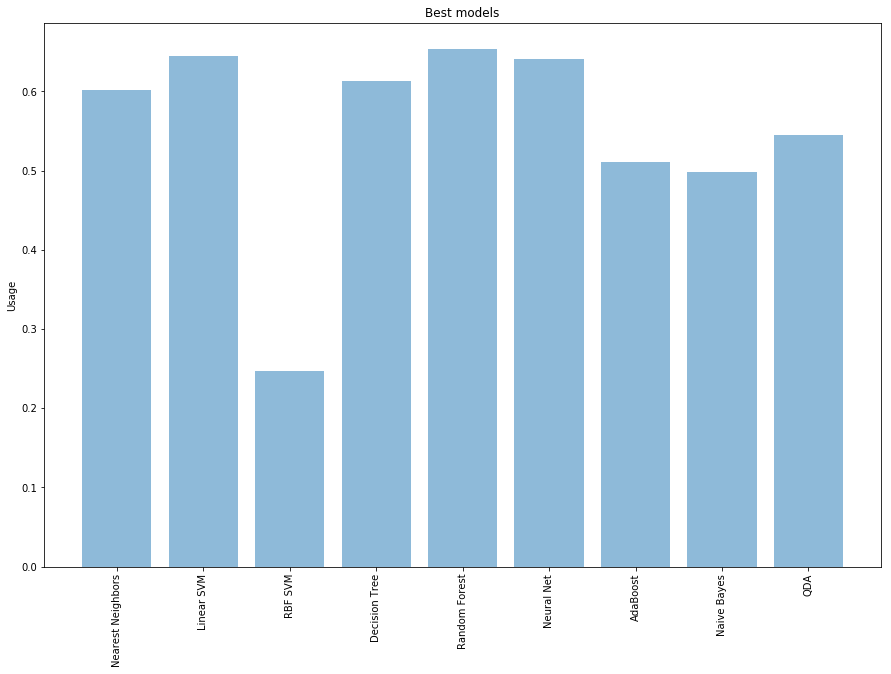

In [9]:
y_pos = np.arange(len(names))
performance = scores
plt.figure(figsize=(15,10))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, names, rotation='vertical')
plt.ylabel('Usage')
plt.title('Best models')

plt.show()

## Best 5 models

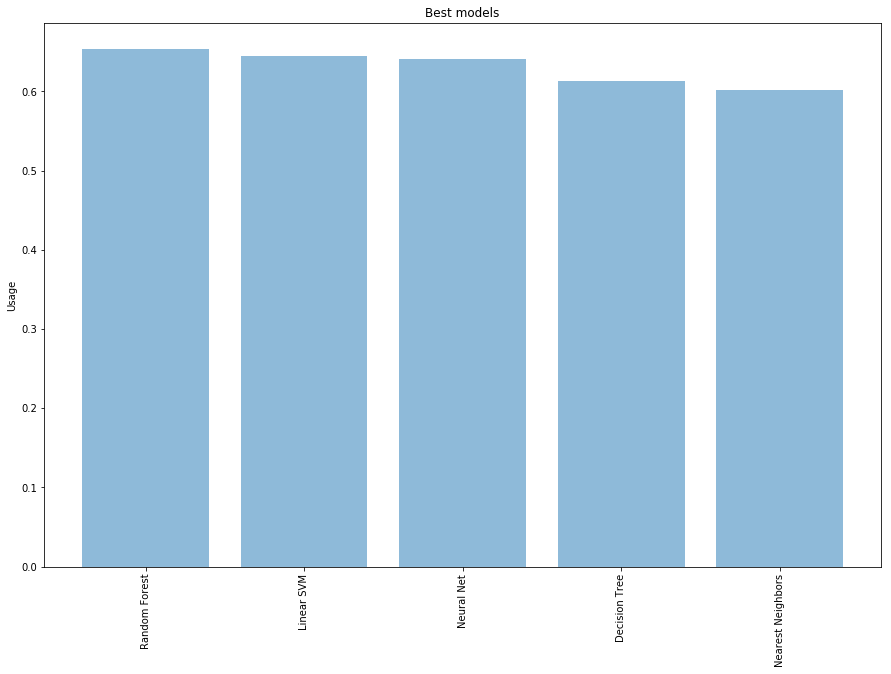

In [10]:
best_idx = np.flip(np.argsort(scores))[:5]
y_pos = np.arange(len(best_idx))
performance = np.asarray(scores)[best_idx]
plt.figure(figsize=(15,10))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, np.asarray(names)[best_idx], rotation='vertical')
plt.ylabel('Usage')
plt.title('Best models')

plt.show()

## Make them vote
Can we improve results by combining them

In [11]:
from sklearn.ensemble import VotingClassifier

In [12]:
best_classifiers_models = np.asarray(classifiers)[best_idx]
best_classifiers_names = np.asarray(names)[best_idx]
best_classifiers_performance = np.asarray(scores)[best_idx]

vote_clf = VotingClassifier(estimators=list(zip(best_classifiers_names, best_classifiers_models)), voting='soft')

In [13]:
scores = []
for _ in range(10):
    vote_clf.fit(X_train,y_train)
    scores.append(vote_clf.score(X_test, y_test))
score = np.mean(scores)

In [14]:
voting_names = np.append(best_classifiers_names,['Voting model'])
voting_perf = np.append(best_classifiers_performance, score)

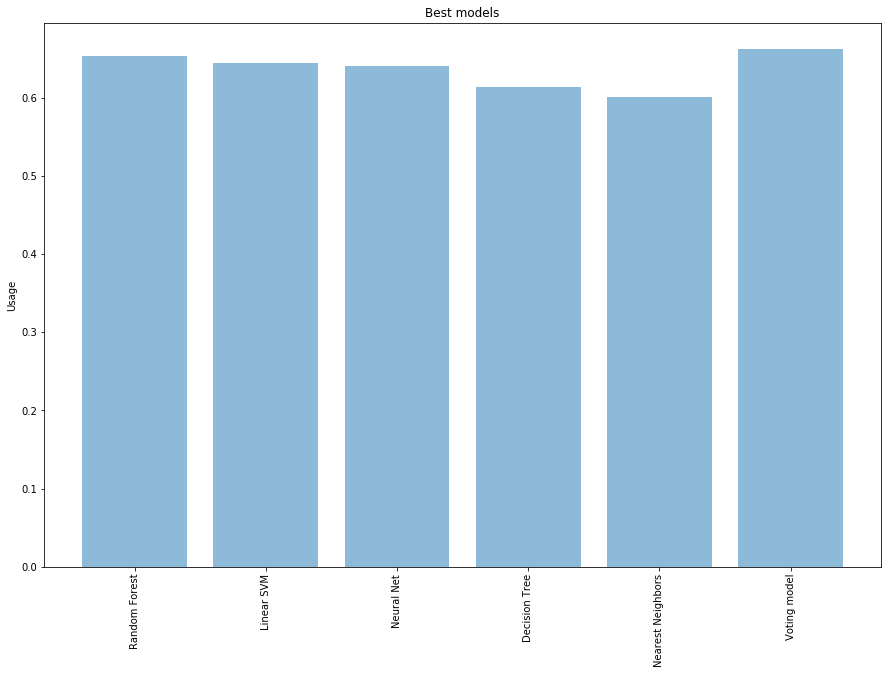

In [15]:
y_pos = np.arange(len(voting_names))
plt.figure(figsize=(15,10))
plt.bar(y_pos, voting_perf, align='center', alpha=0.5)
plt.xticks(y_pos, voting_names, rotation='vertical')
plt.ylabel('Usage')
plt.title('Best models')

plt.show()

### Confusion matrix of voting model

Accuracy: 0.63 (+/- 0.09)


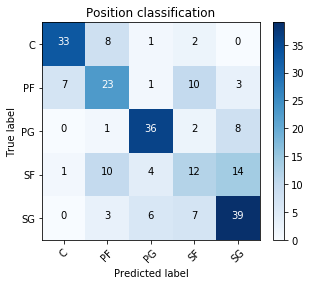

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(vote_clf,X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

y_pred = cross_val_predict(vote_clf,X_test,y_test,cv=5)
acc = accuracy_score(y_pred, y_test)
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

plot_cm(cm, le.classes_, 'Position classification')